In this iPython notebook, we run **SVM and logistic regression**.

In [3]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn import linear_model
from sklearn import cross_validation
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Import Data</h3>

There are 113883 observations in total that overlap with p300. I sampled another 107085 observations from the negative set (no overlap with p300). The total number of observations in the sample set is then **220968**.

In [4]:
data = pd.read_table('data/features_data.txt')
data.head(2)

,H3K27ac,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H4K20me1,TPM,chr,lower,upper,p300
0,0,0,0,0,0,0,0,0,0,10,1,200,0
1,0,0,0,0,0,0,0,0,0,10,201,400,0


In [5]:
print data['p300'].value_counts()

0    14291273
1      113883
dtype: int64


In [6]:
positive = data[data['p300']==1].as_matrix()
nrows = positive.shape[0]
# Select a random sampling of 20000 observations
#select = np.random.choice(nrows, 20000)
#positive = positive[select,:]
print positive.shape

(113883, 13)


Approximate mean difference in positions in data sets. 

In [7]:
positions = positive[:,11]
diff = np.abs(np.diff(positions))
jump = np.mean(diff)
print "Mean: %d" %jump # mean difference in chromosal position, affected by the difference in between chromosomes.

from scipy import stats
m = stats.trim_mean(diff, 0.001) # trimmed mean difference in chromosal position
print "Trimmed mean: %d" %m

Mean: 47801
Trimmed mean: 23009


In [8]:
# Approximate using row indices * 200
indices = data[data['p300']==1].index.values
diff = np.diff(indices)
offset = np.floor(np.mean(np.diff(indices))/2)
select = (indices)+offset.astype(np.int64)
np.mean(np.diff(indices))*200

25295.711350345093

In [9]:
negative = data[data['p300']==0].as_matrix()
nrows = negative.shape[0]
## === Fixed offset from positive set
negative = data.iloc[select]
negative = negative[negative['p300']==0].as_matrix()
## === Constant intervals
# negative = negative[::(data.shape[0]/positive.shape[0])] #take every ~100th row
## === Random sampling
#select = np.random.choice(nrows, 113883) #same size as positive set
#negative = negative[select,:]
print negative.shape

(107085, 13)


In [10]:
test = np.concatenate((positive,negative))
print test.shape

(220968, 13)


In [11]:
X = test[:, [0,1,2,3,4,5,6,7,8]]
print X

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [13]:
y = test[:, 12]
print y

[1 1 1 ..., 0 0 0]


Correlation coefficient matrix

In [13]:
ccoef = np.corrcoef(X, rowvar=0)
i=1
for k in ccoef:
    print np.around(k[:i], decimals=2)
    i=i+1

[ 1.]
[ 0.  1.]
[ 0.02  0.28  1.  ]
[ 0.55  0.03  0.06  1.  ]
[ 0.7  -0.   -0.01  0.57  1.  ]
[ 0.59  0.19  0.14  0.38  0.63  1.  ]
[ 0.69  0.07  0.04  0.39  0.64  0.62  1.  ]
[ 0.05  0.43  0.33  0.09  0.05  0.2   0.11  1.  ]
[ 0.3  -0.03 -0.04  0.19  0.29  0.22  0.28 -0.02  1.  ]


<h3>Run SVM</h3>

In [178]:
from sklearn import svm
clf = svm.LinearSVC(C=0.00001) 

In [179]:
clf.fit(X,y)
coef = clf.coef_
coef = [item for sublist in coef for item in sublist] #flatten list
print coef
#coef = np.absolute(coef) #take absolute value of the coefficients/feature weights

[0.15368937217592862, 0.046903233860721309, 0.040600867027019927, 0.18793128638958034, 0.21082283287521625, 0.18821221105391778, 0.10121698799289888, 0.048624685778320895, 0.05499453985529465]


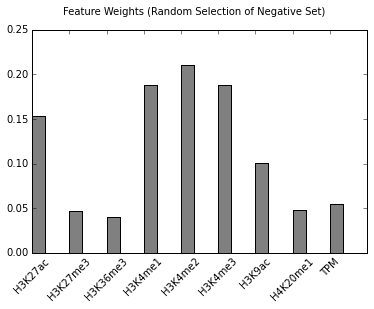

In [180]:
import matplotlib.pyplot as plt
%matplotlib inline

feature_names = data.columns.values
feature_names = feature_names[:9]
#print zip(feature_names, coef)

ind = np.arange(9)  
width = 0.35       

fig, ax = plt.subplots()
rects = ax.bar(ind, coef, width, color='gray')
ax.set_xticklabels(feature_names,rotation=45)
plt.suptitle("Feature Weights (Random Selection of Negative Set)")
plt.show()

0.708699705717


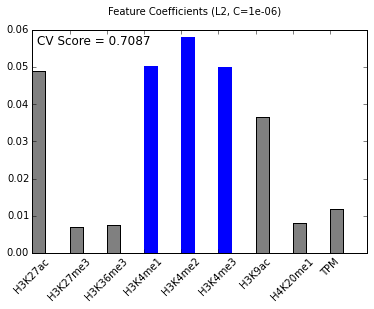

0.515382317867


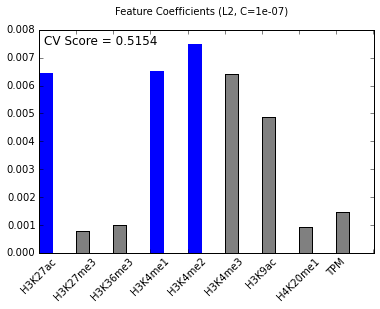

0.515382317867


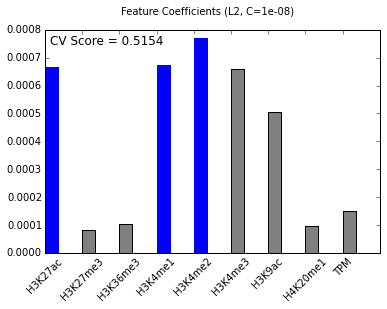

In [183]:
from sklearn import linear_model
from sklearn import cross_validation
regs = [0.11, 0.00001, 0.0000001]
for reg in regs: 
    clf = svm.LinearSVC(C=reg) 
    clf.fit(X,y)
    scores = cross_validation.cross_val_score(clf, X, y, cv=10)
    cv = sum(scores) / float(len(scores))
    print cv

    import matplotlib.pyplot as plt
    %matplotlib inline
    coef = clf.coef_
    coef = [item for sublist in coef for item in sublist] #flatten list

    #print coef
    feature_names = data.columns.values
    feature_names = feature_names[:9]
    #print zip(feature_names, coef)

    ind = np.arange(9)  
    width = 0.35       

    coef_np = np.asarray(coef)
    top3 = np.argsort(-coef_np)[:3]

    fig, ax = plt.subplots()
    rects = ax.bar(ind, coef, width, color='gray')
    for index in top3:
        rects[index].set_color('b')
    ax.set_xticklabels(feature_names,rotation=45)
    plt.suptitle("Feature Coefficients (L2, C=%s)" %reg)
    ax.annotate('CV Score = %0.4f'%cv, xy=(0,1), xycoords='axes fraction', fontsize=12,
                    xytext=(5, -5), textcoords='offset points',
                    ha='left', va='top')
    plt.show()

Above is the plot of the absolute value of the feature weights. These are the coefficients for when I run the sample set without separating into training and test set.

<u>Cross-Validation & Predictions on Test Sets</u>

In [181]:
from sklearn import cross_validation
import time

start = time.time()
print "Cross-validation Scores"
print cross_validation.cross_val_score(clf, X, y, cv=5)
end = time.time()
print "Time Elapsed: %d seconds" %(end - start)

Cross-validation Scores
[ 0.71978097  0.71729194  0.71907951  0.69705609  0.70542846]
Time Elapsed: 3 seconds


In [64]:
def print_counts(counts):
    print "Number in Positive Set That Were Misclassified: %d" %c[(0,1)]
    print "Number in Negative Set That Were Misclassified: %d\n" %c[(1,0)]

In [49]:
from sklearn import cross_validation
from collections import Counter
# K-fold cross-validation
cv = cross_validation.KFold(len(y), n_folds=5, shuffle=True)
clf = svm.LinearSVC()

scores = []
results = []
for train_index, test_index in cv:
    clf.fit(X[train_index], y[train_index])
    coef = clf.coef_
    pred = clf.predict(X[test_index])
    counts = Counter(zip(pred, y[test_index]))
    results.append(counts)
    scores.append(clf.score(X[test_index], y[test_index]))

print "Cross-validation Scores"
print scores

#print "\nMisclassified Counts for Each Fold"
#for c in results:
    #print "-\n"
    #print_counts(c)

Cross-validation Scores
[0.71059419830746251, 0.71231388876318047, 0.70885188034574831, 0.70950150476319784, 0.71144751431222142]

Misclassified Counts for Each Fold


In summary, it looks like observations in the positive set are misclassified about 6 times as often as observations in the negative set. The test set has 227766/5 = 45553 observations. On average, **~10300** are misclassified, of which **~8700** are in the positive set and **~1600** are in the negative set.

In [68]:
#from sklearn.cross_validation import train_test_split
#data_train, data_test, labels_train, labels_test = train_test_split(X, y, test_size=0.20, random_state=42)

<u>Run SVM after PCA</u>

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)
print "Explained Variance Ratio"
print(pca.explained_variance_ratio_) 
cp = pca.components_

# Plot the linear combinations
ind = np.arange(9)  
width = 0.35  
feature_names = data.columns.values
feature_names = feature_names[:9]
i=1
# for comb in cp:
#     ax = plt.subplot()
#     ax.bar(ind, comb, width, color='slateblue')
#     ax.set_xticklabels(feature_names,rotation=45)
#     plt.title('Component %d' %i)
#     plt.show()
#     i = i+1

Explained Variance Ratio
[ 0.55626581  0.1196406   0.09153722  0.05973079  0.04928482]


In [12]:
from sklearn import svm
clf = svm.LinearSVC() 
clf.fit(X_pca,y)
coef = clf.coef_
coef = [item for sublist in coef for item in sublist] #flatten list
print coef

[0.57418888185696371, -0.051486572608214647, 0.294460018259879, -0.18185971047702229, -0.12217416176243751]


In [15]:
from sklearn import cross_validation
import time

start = time.time()
print "Cross-validation Scores"
scores = cross_validation.cross_val_score(clf, X, y, cv=10)
cv = sum(scores) / float(len(scores))
end = time.time()
print "Time Elapsed: %d seconds" %(end - start)

Cross-validation Scores
Time Elapsed: 84 seconds


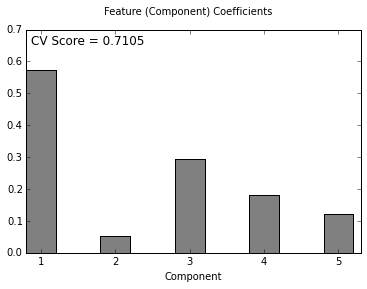

In [19]:
#plot
import matplotlib.pyplot as plt
%matplotlib inline

#print zip(feature_names, coef)

ind = np.arange(5) 
width = 0.4      

ax = plt.subplot()
rects = ax.bar(ind, np.abs(coef), width, color='gray')
plt.xticks(np.arange(5)+0.2)
ax.set_xticklabels(['1','2','3','4','5'])
plt.suptitle("Feature (Component) Coefficients")
plt.xlabel("Component")
ax.annotate('CV Score = %0.4f'%cv, xy=(0,1), xycoords='axes fraction', fontsize=12,
                    xytext=(5, -5), textcoords='offset points',
                    ha='left', va='top')
plt.ylim(0, 0.7)
plt.show()

<h3>Run Logistic Regression</h3>
with L1 and L2 penalty

L1 penalty

In [31]:
from sklearn import linear_model
from sklearn import cross_validation
logreg = linear_model.LogisticRegression(penalty='l1')
logreg.fit(X,y)
print cross_validation.cross_val_score(logreg, X, y, cv=10)

[ 0.7259028   0.71020002  0.71671644  0.71543648  0.70778839  0.72995112
  0.69510319  0.69845221  0.7112147   0.69523896]


[0.38727166617776415, 0.85497772687939932, 0.25372190903794417, 0.80513283100907951, 0.92000653675462596, 0.90723554259955286, -0.014911816541343922, 0.86835968206882419, 1.2209074550547834]


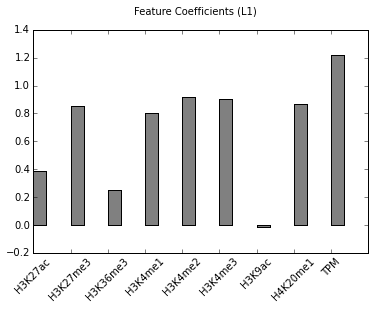

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
coef = logreg.coef_
coef = [item for sublist in coef for item in sublist] #flatten list

print coef
feature_names = data.columns.values
feature_names = feature_names[:9]
#print zip(feature_names, coef)

ind = np.arange(9)  
width = 0.35       

fig, ax = plt.subplots()
rects = ax.bar(ind, coef, width, color='gray')
ax.set_xticklabels(feature_names,rotation=45)
plt.suptitle("Feature Coefficients (L1)")
plt.show()

L2 penalty

0.71060043056


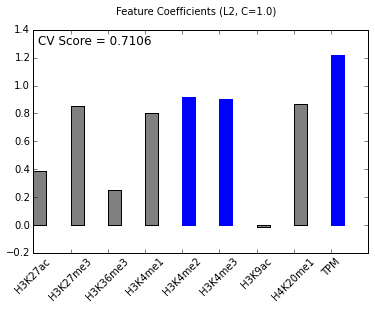

0.710604957086


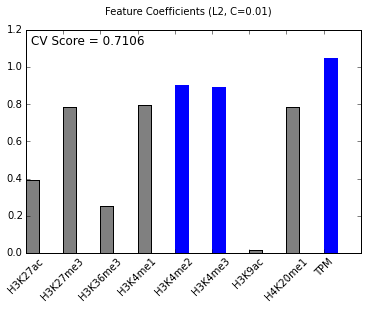

0.711179694305


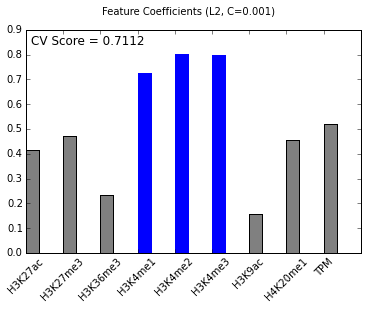

0.711763489081


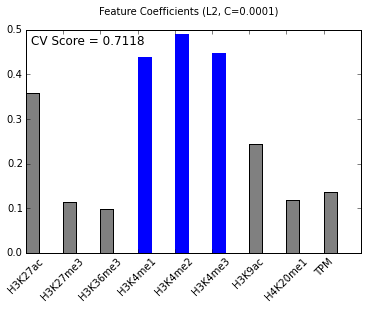

0.713347437441


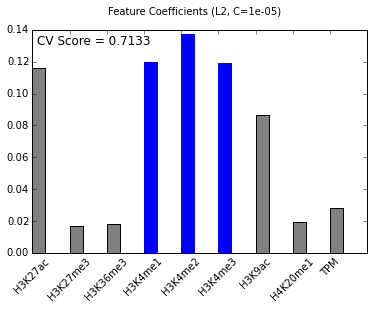

0.707857980106


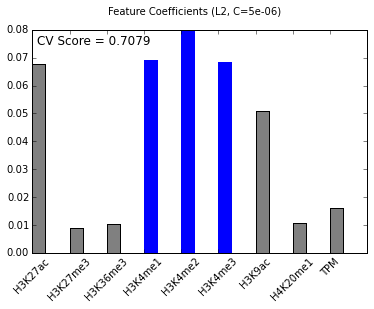

0.515382317867


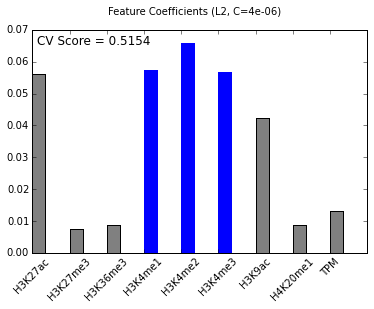

In [14]:
from sklearn import linear_model
from sklearn import cross_validation
regs = [1.0, 0.01, 0.001, 0.0001, 0.00001, 0.000005, 0.000004]
for reg in regs: 
    logreg2 = linear_model.LogisticRegression(penalty='l2', C=reg)
    logreg2.fit(X,y)
    scores = cross_validation.cross_val_score(logreg2, X, y, cv=10)
    cv = sum(scores) / float(len(scores))
    print cv

    import matplotlib.pyplot as plt
    %matplotlib inline
    coef = logreg2.coef_
    coef = [item for sublist in coef for item in sublist] #flatten list

    #print coef
    feature_names = data.columns.values
    feature_names = feature_names[:9]
    #print zip(feature_names, coef)

    ind = np.arange(9)  
    width = 0.35       

    coef_np = np.asarray(coef)
    top3 = np.argsort(-coef_np)[:3]

    fig, ax = plt.subplots()
    rects = ax.bar(ind, coef, width, color='gray')
    for index in top3:
        rects[index].set_color('b')
    ax.set_xticklabels(feature_names,rotation=45)
    plt.suptitle("Feature Coefficients (L2, C=%s)" %reg)
    ax.annotate('CV Score = %0.4f'%cv, xy=(0,1), xycoords='axes fraction', fontsize=12,
                    xytext=(5, -5), textcoords='offset points',
                    ha='left', va='top')
    plt.show()

Elastic Net (learned with Stochastic Gradient Descent) --unfinished--

In [36]:
from sklearn import linear_model
from sklearn import cross_validation
logregen = linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15)
logregen.fit(X,y)
print cross_validation.cross_val_score(logregen, X, y, cv=10)

[ 0.48461399  0.48461399  0.48461399  0.48463592  0.48463592  0.4846126
  0.4846126   0.4846126   0.4846126   0.4846126 ]
